In [100]:
import sys
import os
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scikit_posthocs import posthoc_nemenyi
import pandas as pd

import seaborn as sns
import joblib

from kan import KAN
from sklearn.metrics import mean_squared_error


sys.path.append("../../")

from analysis_functions import (
    test_after_opt,
    split_transform_one_comp_cv,
    opener,
    KANModelTrainTest,
    clean_input_array,
)


In [101]:
# Load data
X_stress_components_new = opener(
    "X_stress_components_new_components", path_import="../../new_components_resources/"
)
y_stress_components_new = opener(
    "y_stress_components_new_components", path_import="../../new_components_resources/"
)

print(X_stress_components_new.shape)

component_num = 2
X_current = X_stress_components_new[component_num]
y_current = y_stress_components_new[component_num]

../../new_components_resources//X_stress_components_new_components.pkl
../../new_components_resources//y_stress_components_new_components.pkl
(3, 1597, 5)


Загрузка KAN

In [102]:
model = KAN.loadckpt(
    "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/ml_core_kan_components/testing_final_models/saved_models/2/model/"
    + "0.1"
)
kan_model = KANModelTrainTest(False)
kan_model.model = model
kan_model.create_train_val_test(
    X_current,
    y_current,
)

X_test, y_test, _, _, train_list_X, train_list_y = split_transform_one_comp_cv(
    X_current, y_current, n_splits=1
)
X_test, y_test = clean_input_array(X_test, y_test)
my_dataset = kan_model.create_dataset(
    kan_model.train_set_X[0],
    kan_model.train_set_y[0],
    kan_model.cur_X_test,
    kan_model.cur_y_test,
)

# Получаем предсказания

kan_predictions = model(my_dataset["test_input"]).detach().numpy()
truth = my_dataset["test_label"].detach().numpy()
kan_errors = np.sqrt(np.mean((truth - kan_predictions) ** 2, axis=1))
kan_errors = (y_test - kan_predictions.ravel()) ** 2


2025-05-11 23:25:24,756 - INFO - Using device: cpu


In [103]:
kan_errors

array([1.64063957e+04, 1.33320739e+04, 1.01667227e+04, ...,
       1.50689929e+01, 1.05711092e+01, 6.25454967e-01])

Загрузка MLP

In [104]:
input_size = 6
output_size = 1

best_mlp_params = {
    "n_layers": 2,
    "n_units_0": 53,
    "n_units_1": 97,
    "activation": "tanh",
    "learning_rate": 0.0033923538523987205,
    "batch_size": 128,
    "optimizer": "Adam",
    "max_epochs": 204,
}

# Instantiate the model with the same architecture
# You'll need to import your model class, e.g., from gpu_optuna import MLPNetwork
# This assumes MLPNetwork is defined in gpu_optuna and takes these params
# You might need to adjust this based on your actual MLPNetwork class definition
from gpu_optuna import (
    MLPNetwork,
    predict_with_model,
)

mlp_model = MLPNetwork(
    layer_sizes=[input_size]
    + [best_mlp_params[f"n_units_{i}"] for i in range(best_mlp_params["n_layers"])]
    + [output_size],
    activation=best_mlp_params["activation"],
)
model_path = "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/ml_core_mlp_compoments/testing_final_models/models/mlp_regressor_model_2.pth"
# Load the saved state dictionary
mlp_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode (important for inference)
mlp_model.eval()

print(f"Model loaded from {model_path} and set to evaluation mode.")

# Получаем предсказания


# Get training data
X_train = train_list_X[0]
y_train = train_list_y[0]

# Clean input arrays (handle NaNs, etc.)
X_train, y_train = clean_input_array(X_train, y_train)
X_test, y_test = clean_input_array(X_test, y_test)

# Convert to PyTorch tensors
device = "cpu"
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1)).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1)).to(device)

# Create standardization parameters
mean = X_train_tensor.mean(0, keepdim=True)
std = X_train_tensor.std(0, unbiased=False, keepdim=True)
std[std == 0] = 1  # prevent division by zero

mlp_predictions = predict_with_model(mlp_model, X_test, mean, std)

mlp_errors = np.sqrt(
    np.mean((y_test.reshape(-1, 1) - mlp_predictions) ** 2, axis=1)
)

mlp_errors = (y_test - mlp_predictions.ravel()) ** 2

# mlp_errors = mean_squared_error(
#     y_test.reshape(1, -1), mlp_predictions, multioutput="raw_values"
# )


Model loaded from /Users/i.grebenkin/pythonProjects/учеба/wire_drawing/ml_core_mlp_compoments/testing_final_models/models/mlp_regressor_model_2.pth and set to evaluation mode.


In [105]:
mlp_errors

array([814.05777393, 324.4473119 , 107.44309728, ...,   3.8642181 ,
        11.55916439,   8.14505641])

Загрузка Decision Tree

In [106]:
decision_tree_model = joblib.load(
    "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/simple_ml_models/new_components/2/decision_tree/best_decision_tree_model.pkl"
)

# Predict using the best model
dt_cur_y_pred_best = decision_tree_model.predict(X_test)

# Evaluate the best model
dt_errors = mean_squared_error(
    y_test.reshape(1, -1), dt_cur_y_pred_best.reshape(1, -1), multioutput="raw_values"
)

In [107]:
dt_errors

array([3.85890665e+00, 8.96936611e+00, 5.64304776e+00, ...,
       4.35129877e-01, 9.22046510e-02, 8.38247256e-04])

Загрузка Gradient Boosting

In [108]:
from sklearn.ensemble import GradientBoostingRegressor
import pickle

# Load the best model
gradient_boosting_model = joblib.load(
    "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/simple_ml_models/new_components/2/gradient_boosting/best_gradient_boosting_model.pkl"
)

# Predict using the best model
gb_cur_y_pred_best = gradient_boosting_model.predict(X_test)
# Evaluate the best model
# gb_errors = np.sqrt(
#     np.mean((y_test.reshape(1, -1) - gb_cur_y_pred_best.reshape(1, -1)) ** 2, axis=0)
# )
gb_errors = mean_squared_error(
    y_test.reshape(1, -1), gb_cur_y_pred_best.reshape(1, -1), multioutput="raw_values"
)



In [109]:
gb_errors

array([ 33.52726173, 116.703606  ,  81.17083803, ...,   6.28102547,
         5.35494724,   2.65059915])

In [110]:
# Соберите ошибки всех доступных моделей в DataFrame
errors_df = pd.DataFrame({
    'KAN': kan_errors,
    'MLP': mlp_errors,
    'Decision Tree': dt_errors,
    'Gradient Boosting': gb_errors
})

# Проведение теста Фридмана
friedman_stat, p_value = stats.friedmanchisquare(
    errors_df['KAN'], 
    errors_df['MLP'], 
    errors_df['Decision Tree'],
    errors_df['Gradient Boosting']
)

print(f"Статистика Фридмана: {friedman_stat:.4f}")
print(f"p-значение: {p_value:.6f}")

Статистика Фридмана: 2433.6858
p-значение: 0.000000


In [111]:
# save errors_df
errors_df.to_csv(
    "errors_df_2.csv",
    index=False,
)

## Тест Неменьи (Post-hoc анализ)

Если тест Фридмана показывает статистически значимую разницу между моделями (p-значение < 0.05), необходимо выполнить post-hoc анализ для определения, какие конкретные пары моделей отличаются друг от друга. Для этого используется тест Неменьи.

Результаты теста Неменьи (p-значения для попарных сравнений):
     0             1         2             3
0  1.0  0.000000e+00  0.000000  0.000000e+00
1  0.0  1.000000e+00  0.000000  2.313705e-13
2  0.0  0.000000e+00  1.000000  9.060630e-04
3  0.0  2.313705e-13  0.000906  1.000000e+00


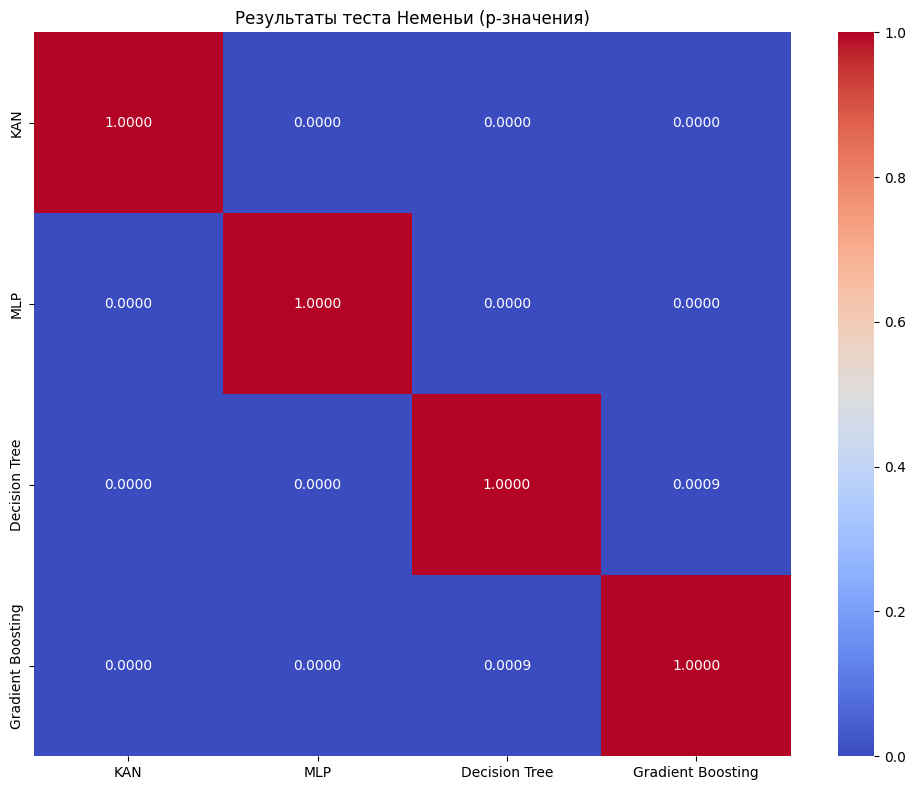

In [112]:
from scikit_posthocs import posthoc_nemenyi_friedman

# Преобразуем DataFrame в массив numpy для использования с posthoc_nemenyi_friedman
# Данные должны иметь форму: строки - блоки (тестовые образцы), столбцы - группы (модели)
errors_array = errors_df.values

# Проведение теста Неменьи
nemenyi_result = posthoc_nemenyi_friedman(errors_array)

print("Результаты теста Неменьи (p-значения для попарных сравнений):")
print(nemenyi_result)

# Визуализация результатов теста Неменьи с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_result, annot=True, cmap='coolwarm', fmt='.4f', 
            xticklabels=errors_df.columns, yticklabels=errors_df.columns)
plt.title('Результаты теста Неменьи (p-значения)')
plt.tight_layout()
plt.show()

In [113]:
# Интерпретация результатов
alpha = 0.05  # Уровень значимости

# Создаем DataFrame для хранения результатов сравнения
comparison_results = pd.DataFrame(index=errors_df.columns, columns=errors_df.columns)

# Заполняем DataFrame результатами
for i in range(len(errors_df.columns)):
    for j in range(len(errors_df.columns)):
        model_i = errors_df.columns[i]
        model_j = errors_df.columns[j]
        p_value = nemenyi_result.iloc[i, j]
        
        if i == j:  # Диагональ - сравнение модели с самой собой
            comparison_results.loc[model_i, model_j] = '-'
        else:
            if p_value < alpha:
                comparison_results.loc[model_i, model_j] = f'Значимо (p={p_value:.4f})'
            else:
                comparison_results.loc[model_i, model_j] = f'Не значимо (p={p_value:.4f})'

print("Интерпретация попарных сравнений (уровень значимости α=0.05):")
comparison_results

Интерпретация попарных сравнений (уровень значимости α=0.05):


KAN                 MLP       Decision Tree  \
KAN                                 -  Значимо (p=0.0000)  Значимо (p=0.0000)   
MLP                Значимо (p=0.0000)                   -  Значимо (p=0.0000)   
Decision Tree      Значимо (p=0.0000)  Значимо (p=0.0000)                   -   
Gradient Boosting  Значимо (p=0.0000)  Значимо (p=0.0000)  Значимо (p=0.0009)   

                    Gradient Boosting  
KAN                Значимо (p=0.0000)  
MLP                Значимо (p=0.0000)  
Decision Tree      Значимо (p=0.0009)  
Gradient Boosting                   -

## Интерпретация результатов

При интерпретации результатов теста Неменьи:

1. **p-значение < 0.05** означает, что между двумя моделями существует статистически значимое различие в точности (ошибке предсказания).

2. **p-значение ≥ 0.05** означает, что нет статистически значимых доказательств различия в точности моделей.

Тепловая карта выше позволяет визуально интерпретировать эти результаты, где более тёмные цвета соответствуют более низким p-значениям (т.е. более значимым различиям).

Средние ошибки моделей (по возрастанию):
MLP: 76.084189
Gradient Boosting: 91.529422
Decision Tree: 107.824658
KAN: 289.452698


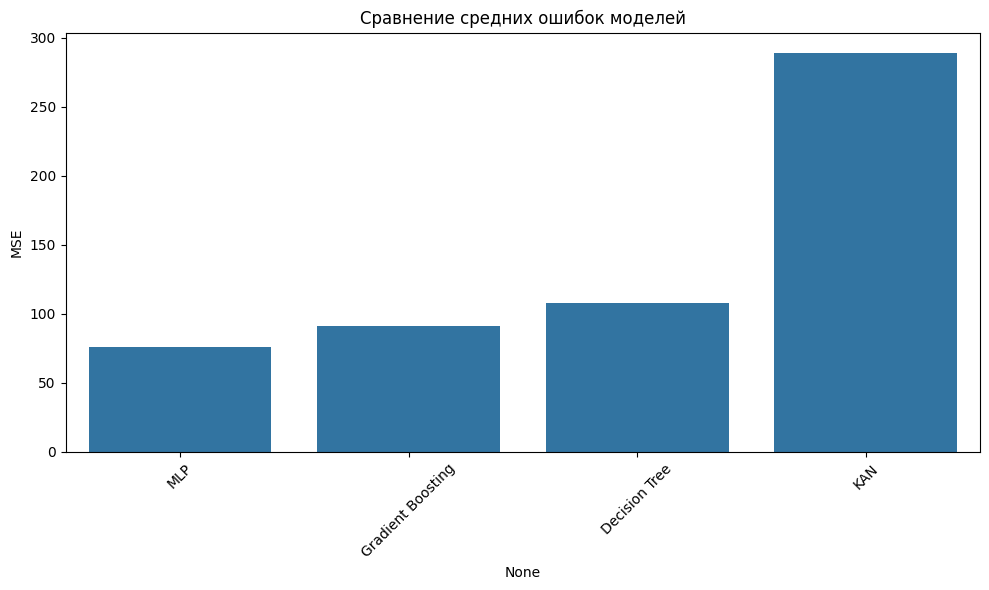

In [114]:
# Рассчитаем средние ошибки для каждой модели и ранжируем их
mean_errors = errors_df.mean().sort_values()
print("Средние ошибки моделей (по возрастанию):")
for model, error in mean_errors.items():
    print(f"{model}: {error:.6f}")

# Визуализация средних ошибок
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_errors.index, y=mean_errors.values)
plt.title('Сравнение средних ошибок моделей')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Выводы

1. Тест Фридмана показывает, есть ли статистически значимые различия между всеми моделями в целом.

2. Тест Неменьи (post-hoc) определяет, между какими конкретно парами моделей существуют значимые различия.

3. Сравнение средних ошибок позволяет ранжировать модели по точности и выбрать лучшую для данной задачи.

Эти статистические тесты помогают обосновать выбор модели не только на основе средних показателей ошибок, но и с учетом статистической значимости различий между моделями.

Сравнительные графики предсказаний

In [117]:
X_test.shape


(4800, 6)

In [116]:
kan_predictions_ravel = kan_predictions.ravel()
mlp_predictions_ravel = mlp_predictions.ravel()

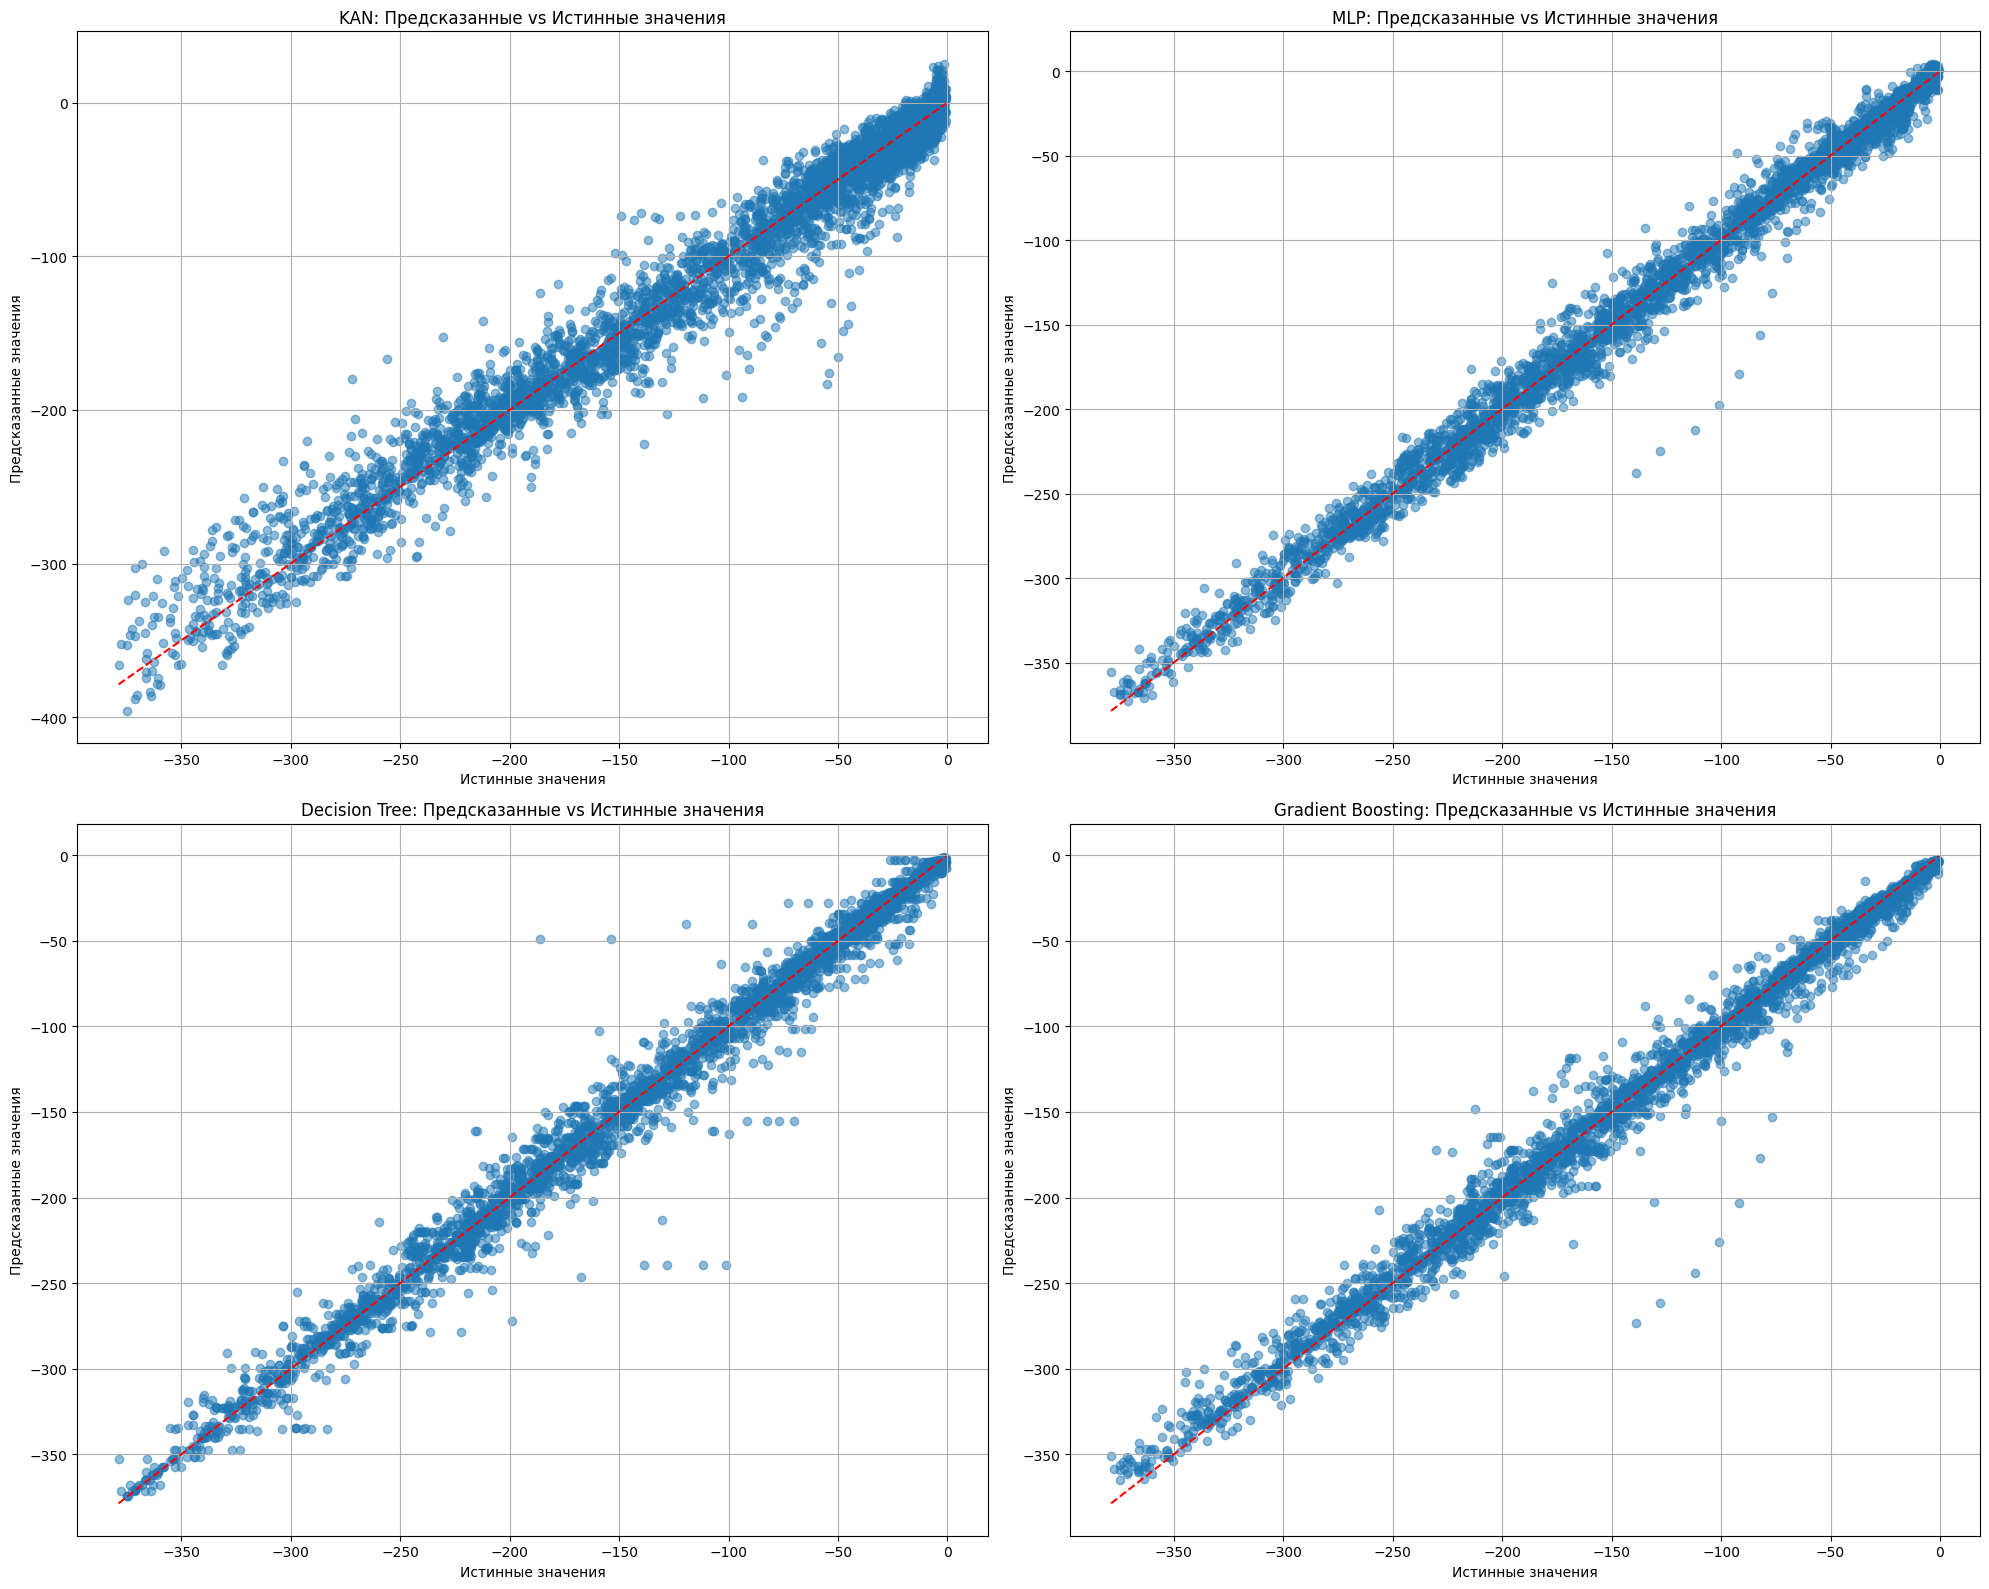

In [124]:
# График рассеяния для сравнения предсказаний с истинными значениями (scatter plots)

plt.figure(figsize=(20, 16))

# 1. KAN
plt.subplot(2, 2, 1)
plt.scatter(y_test, kan_predictions_ravel, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('KAN: Предсказанные vs Истинные значения')
plt.grid(True)

# 2. MLP
plt.subplot(2, 2, 2)
plt.scatter(y_test, mlp_predictions_ravel, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('MLP: Предсказанные vs Истинные значения')
plt.grid(True)

# 3. Decision Tree
plt.subplot(2, 2, 3)
plt.scatter(y_test, dt_cur_y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Decision Tree: Предсказанные vs Истинные значения')
plt.grid(True)

# 4. Gradient Boosting
plt.subplot(2, 2, 4)
plt.scatter(y_test, gb_cur_y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Gradient Boosting: Предсказанные vs Истинные значения')
plt.grid(True)

plt.tight_layout()
plt.show()

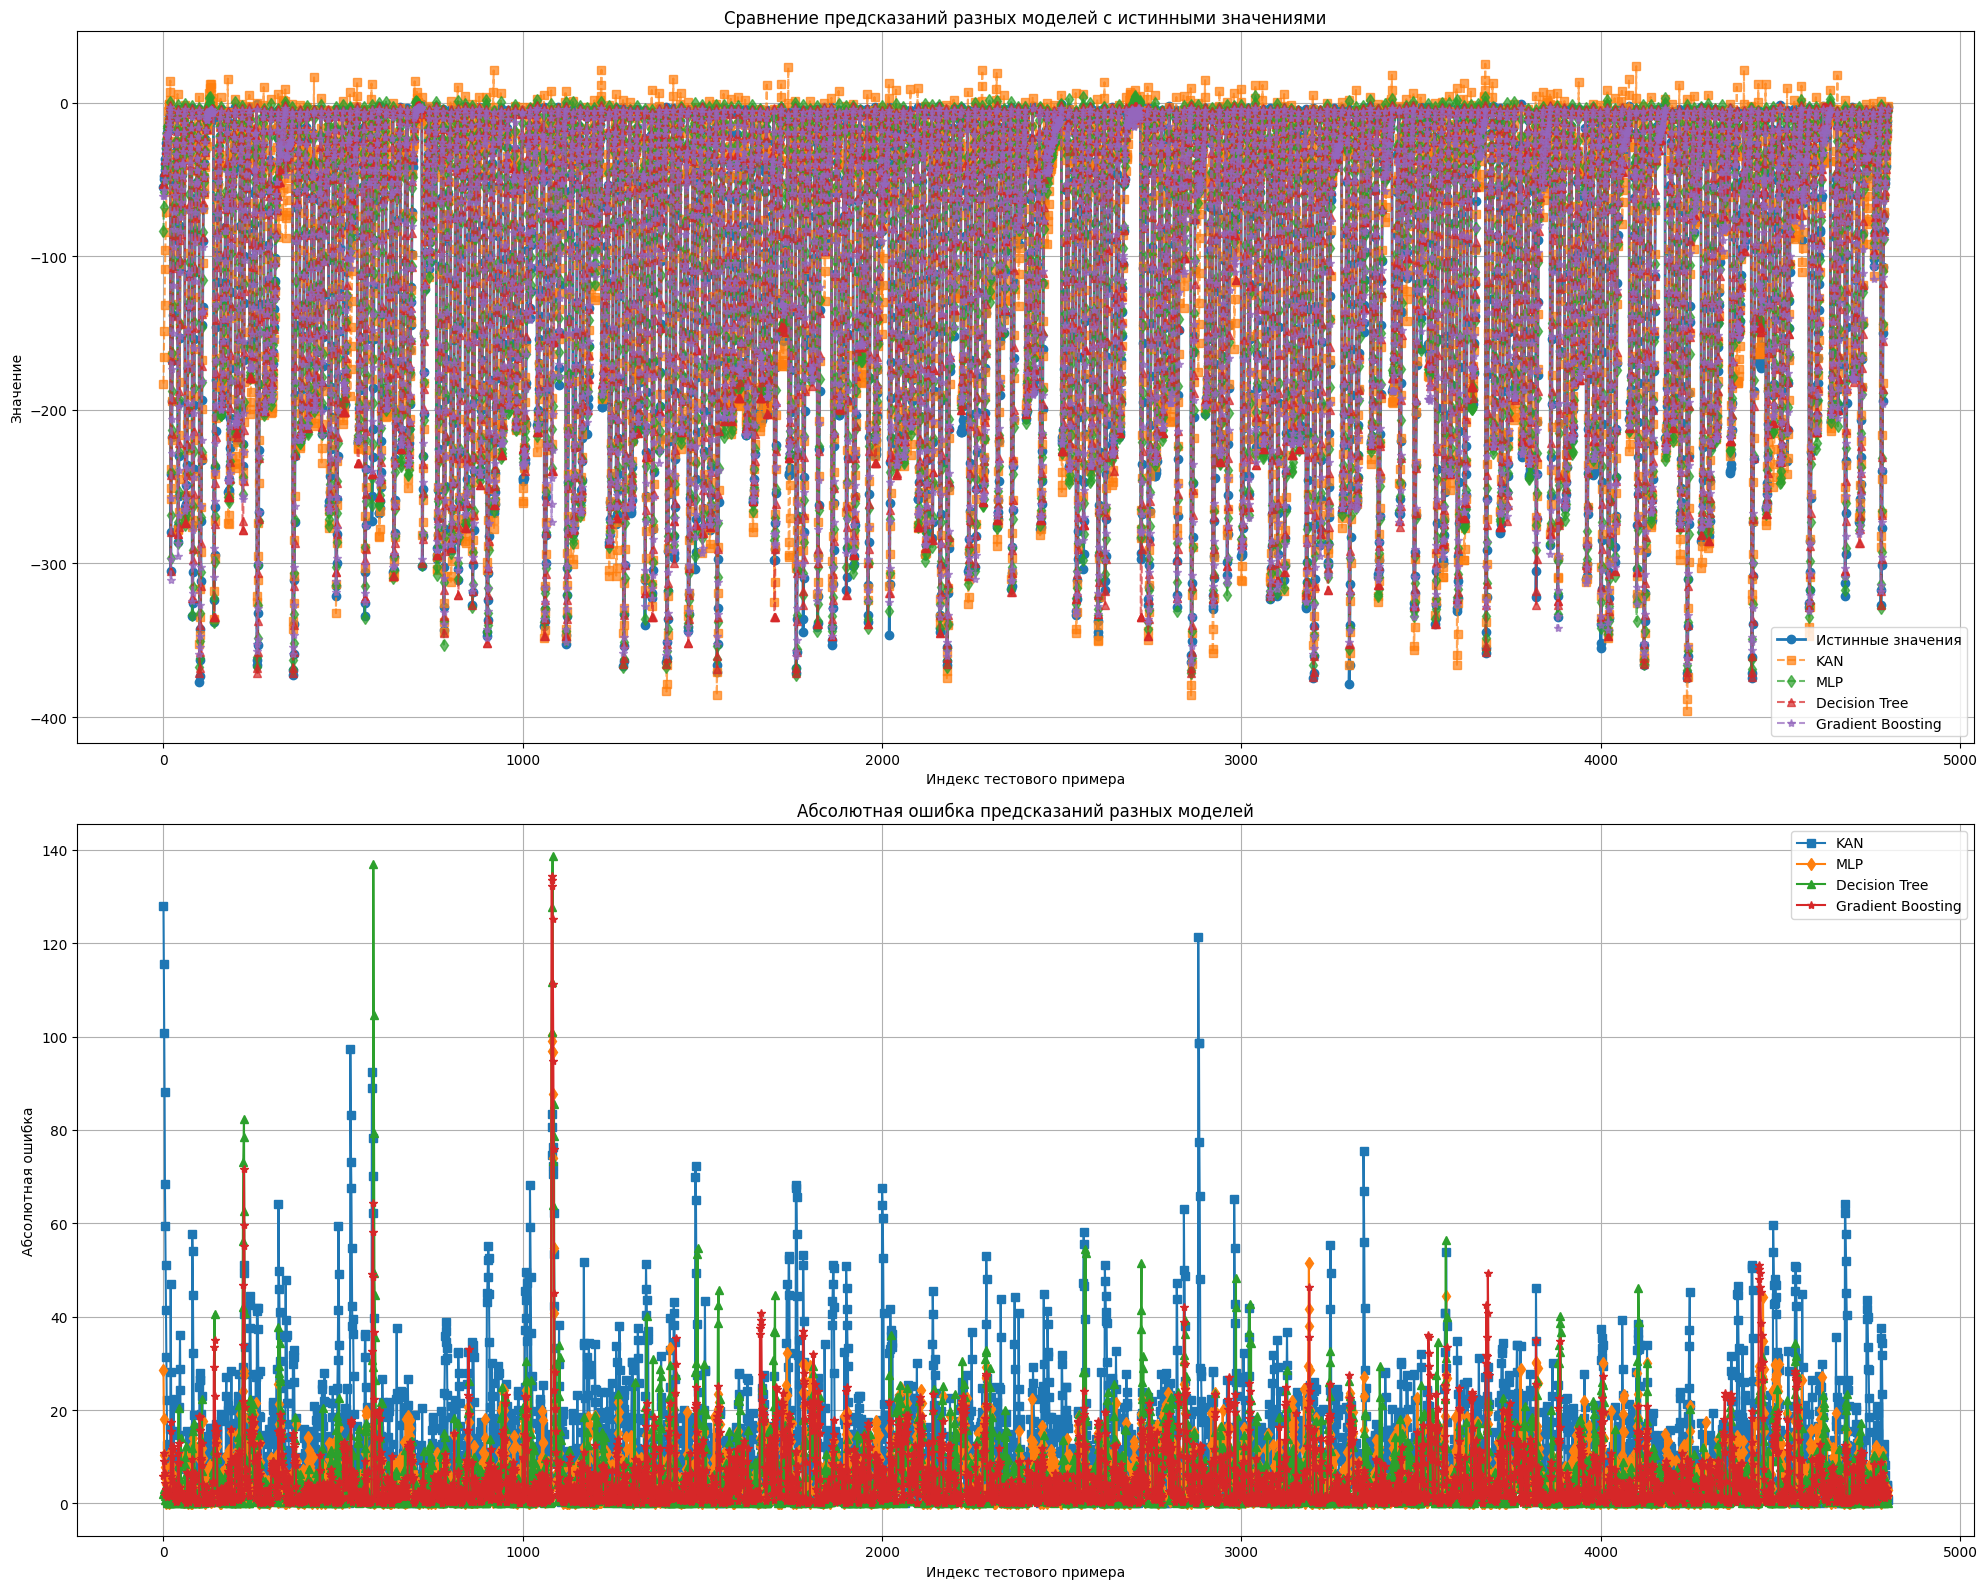

In [127]:
# Линейный график предсказаний всех моделей в сравнении с истинными значениями

fig, axes = plt.subplots(2, 1, figsize=(20, 16))

x_indices = np.arange(len(y_test))
# Верхний график - все предсказания на одном графике
axes[0].plot(x_indices, y_test, 'o-', label='Истинные значения', linewidth=2)
axes[0].plot(x_indices, kan_predictions_ravel, 's--', label='KAN', linewidth=1.5, alpha=0.7)
axes[0].plot(x_indices, mlp_predictions_ravel, 'd--', label='MLP', linewidth=1.5, alpha=0.7)
axes[0].plot(
    x_indices,
    dt_cur_y_pred_best,
    "^--",
    label="Decision Tree",
    linewidth=1.5,
    alpha=0.7,
)
axes[0].plot(
    x_indices,
    gb_cur_y_pred_best,
    "*--",
    label="Gradient Boosting",
    linewidth=1.5,
    alpha=0.7,
)

axes[0].set_xlabel('Индекс тестового примера')
axes[0].set_ylabel('Значение')
axes[0].set_title('Сравнение предсказаний разных моделей с истинными значениями')
axes[0].legend()
axes[0].grid(True)

# Нижний график - ошибки предсказаний (разница между предсказанием и истинным значением)
kan_errors_line = np.abs(kan_predictions_ravel - y_test)
mlp_errors_line = np.abs(mlp_predictions_ravel - y_test)
dt_errors_line = np.abs(dt_cur_y_pred_best - y_test)
gb_errors_line = np.abs(gb_cur_y_pred_best - y_test)

axes[1].plot(x_indices, kan_errors_line, 's-', label='KAN', linewidth=1.5)
axes[1].plot(x_indices, mlp_errors_line, 'd-', label='MLP', linewidth=1.5)
axes[1].plot(x_indices, dt_errors_line, '^-', label='Decision Tree', linewidth=1.5)
axes[1].plot(x_indices, gb_errors_line, '*-', label='Gradient Boosting', linewidth=1.5)

axes[1].set_xlabel('Индекс тестового примера')
axes[1].set_ylabel('Абсолютная ошибка')
axes[1].set_title('Абсолютная ошибка предсказаний разных моделей')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

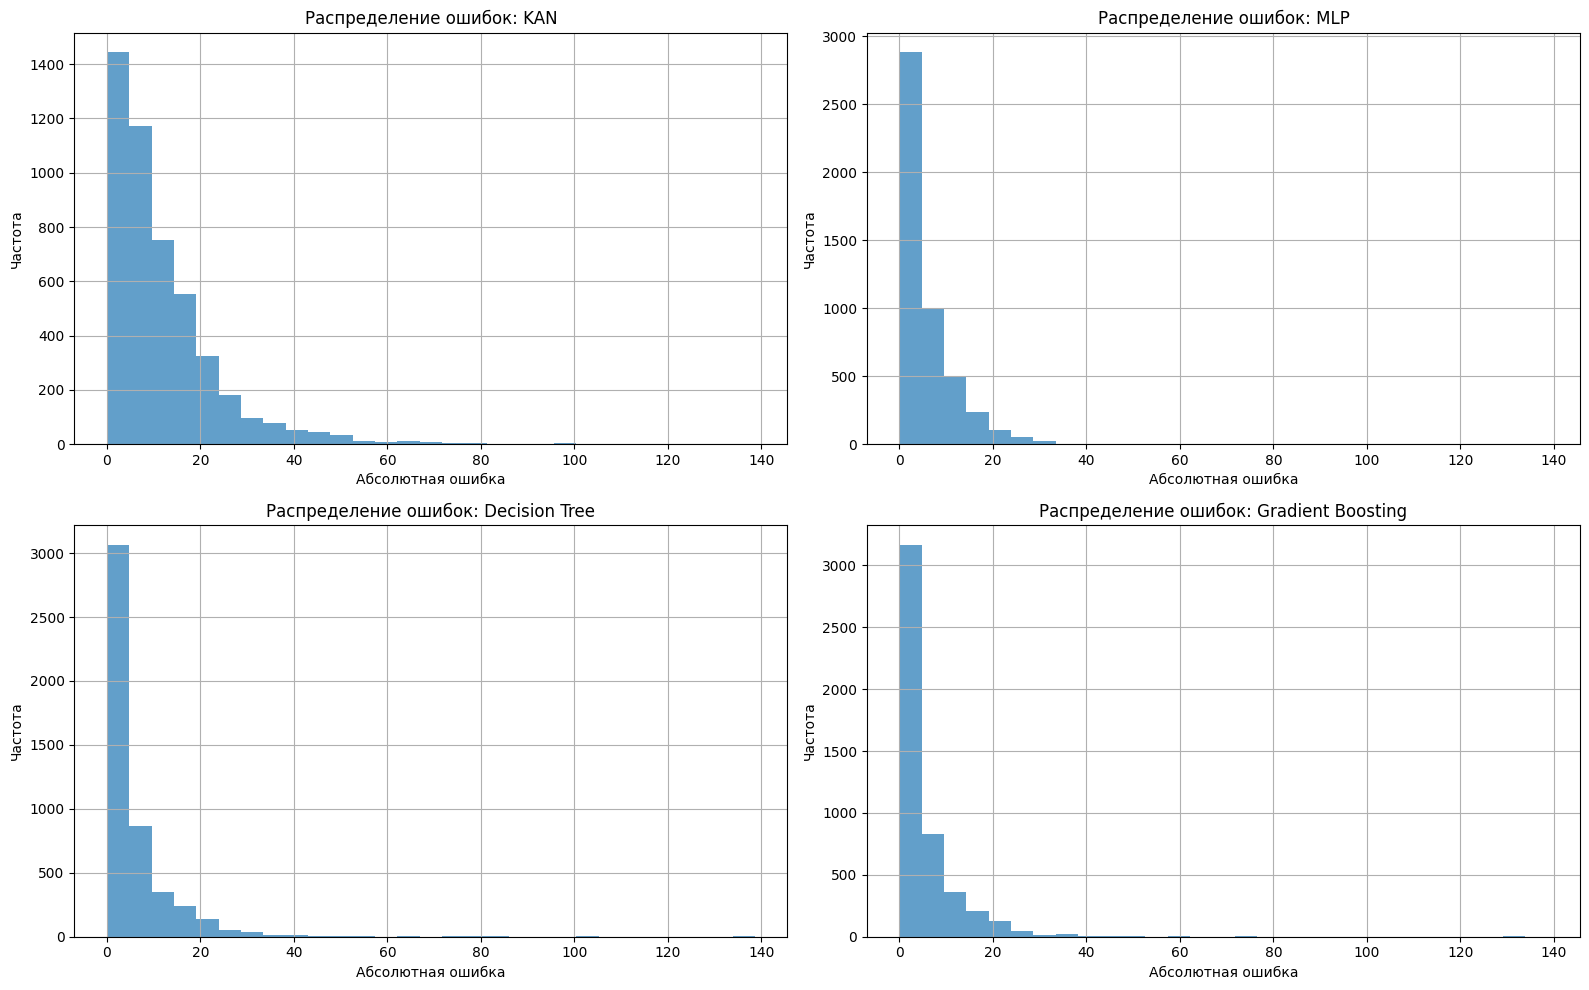

In [128]:
# Гистограммы ошибок предсказаний

plt.figure(figsize=(16, 10))

# Подготовка данных для гистограмм - ошибки предсказаний
errors_dict = {
    'KAN': kan_errors_line,
    'MLP': mlp_errors_line,
    'Decision Tree': dt_errors_line,
    'Gradient Boosting': gb_errors_line
}

# Определение общего диапазона для всех гистограмм
min_error = min([np.min(errors) for errors in errors_dict.values()])
max_error = max([np.max(errors) for errors in errors_dict.values()])
bins = np.linspace(min_error, max_error, 30)

# Построение гистограмм
for i, (model_name, errors) in enumerate(errors_dict.items(), 1):
    plt.subplot(2, 2, i)
    plt.hist(errors, bins=bins, alpha=0.7)
    plt.xlabel('Абсолютная ошибка')
    plt.ylabel('Частота')
    plt.title(f'Распределение ошибок: {model_name}')
    plt.grid(True)

plt.tight_layout()
plt.show()

/var/folders/_d/tbsnrdk10zg3j0zy12r9dprw0000gq/T/ipykernel_45772/2105673596.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=box_labels, showfliers=True)


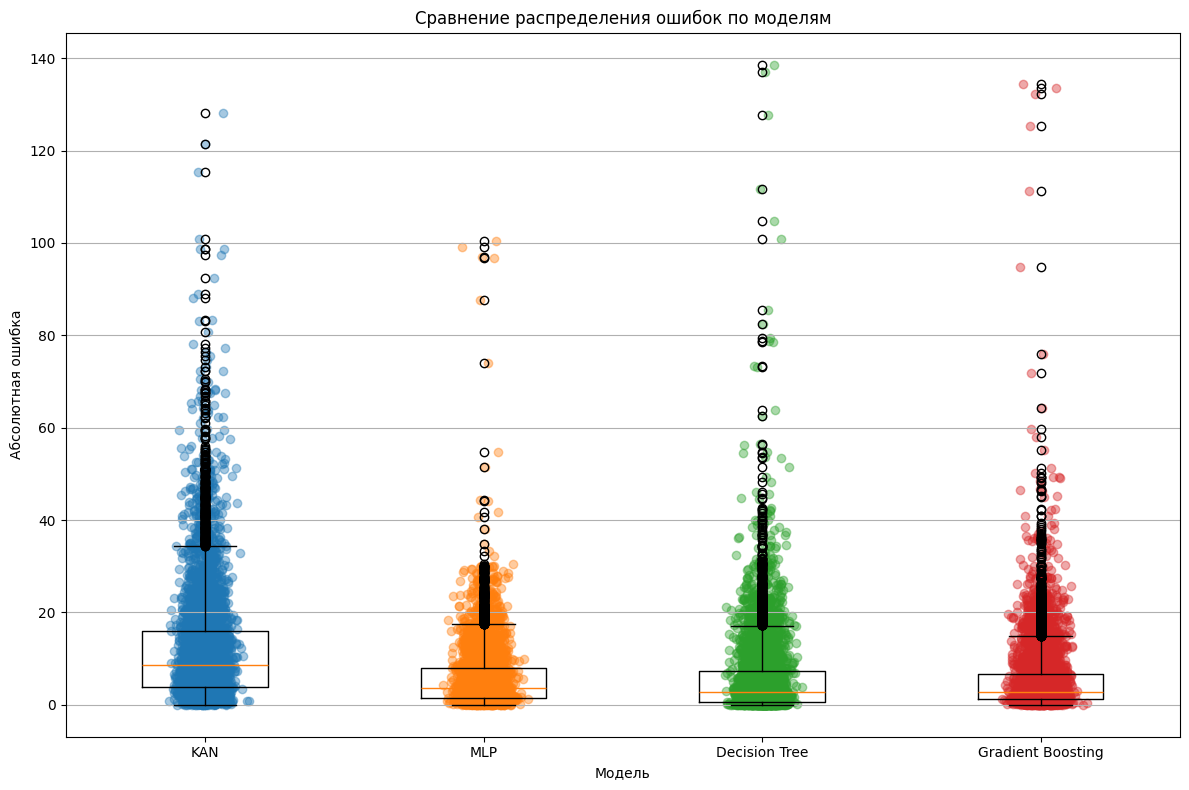

In [129]:
# Диаграммы размаха ошибок (box plots) для сравнения моделей

plt.figure(figsize=(12, 8))

# Подготовка данных для box plot
box_data = [kan_errors_line, mlp_errors_line, dt_errors_line, gb_errors_line]
box_labels = ['KAN', 'MLP', 'Decision Tree', 'Gradient Boosting']

plt.boxplot(box_data, labels=box_labels, showfliers=True)
plt.xlabel('Модель')
plt.ylabel('Абсолютная ошибка')
plt.title('Сравнение распределения ошибок по моделям')
plt.grid(True, axis='y')

# Добавление точек для отображения распределения данных
for i, data in enumerate(box_data):
    # Создание случайного разброса по x для лучшей визуализации
    x = np.random.normal(i+1, 0.04, size=len(data))
    plt.scatter(x, data, alpha=0.4)

plt.tight_layout()
plt.show()

## Выводы по сравнительному анализу графиков предсказаний

По результатам визуального анализа графиков предсказаний и ошибок можно сделать следующие выводы:

1. **График рассеяния (Predicted vs Actual)**: Показывает, насколько точно модели предсказывают истинные значения. Чем ближе точки к диагональной линии, тем точнее модель.

2. **Линейный график предсказаний**: Позволяет увидеть, как разные модели следуют за истинными значениями для каждого тестового примера и где возникают ошибки.

3. **График абсолютных ошибок**: Демонстрирует, для каких тестовых примеров модели делают наибольшие ошибки, что может помочь обнаружить проблемные участки данных.

4. **Гистограммы ошибок**: Показывают распределение ошибок для каждой модели. Модель с более узким и смещенным влево распределением обычно предпочтительнее.

5. **Диаграммы размаха (Box Plots)**: Визуализируют медиану, квартили и выбросы в ошибках предсказаний. Модель с меньшим размером коробки, меньшей медианой и меньшим количеством выбросов обычно лучше.

Сочетание этих визуализаций с результатами статистических тестов (Фридман и Неменьи) даёт полную картину сравнительной эффективности моделей.

## Анализ предсказаний моделей для одного технологического процесса (при изменении одного параметра)

Исследуем как разные модели предсказывают результаты для одного и того же технологического процесса с фиксированными параметрами X_test[0:4] и при изменении параметра X_test[5].

In [ ]:
# Функция для форматирования параметров технологического процесса с понятными названиями и единицами измерения
def format_process_params(params):
    """
    Преобразует кортеж числовых параметров в форматированную строку с подписями и единицами измерения.

    Параметры:
    params[0] - обжатие, в десятичной форме (например, 0.2 = 20%)
    params[1] - коэффициент калибрующего участка (к.к.у.)
    params[2] - угол, градусы
    params[3] - коэффициент трения
    params[4] - скорость, м/мин
    """
    if len(params) < 5:
        return str(params)  # Вернуть исходный формат, если недостаточно параметров

    # Преобразование в понятный формат с единицами измерения
    formatted_params = f"Параметры: обжатие {params[0] * 100:.1f}%, к.к.у. {params[1]:.1f}, угол {params[2]:.1f}º, к-т трения {params[3]:.3f}, скорость {params[4]:.1f} м/мин"

    return formatted_params

Форма массива X_test: (4800, 6)
Первые несколько строк X_test:
[[ 0.2         0.5        16.          0.025      10.          0.        ]
 [ 0.2         0.5        16.          0.025      10.          0.05263158]
 [ 0.2         0.5        16.          0.025      10.          0.10526316]
 [ 0.2         0.5        16.          0.025      10.          0.15789474]
 [ 0.2         0.5        16.          0.025      10.          0.21052632]]

Найдено 240 уникальных наборов первых 5 параметров

Параметры: обжатие 20.0%, к.к.у. 0.5, угол 16.0º, к-т трения 0.025, скорость 10.0 м/мин
Количество образцов с этими параметрами: 20


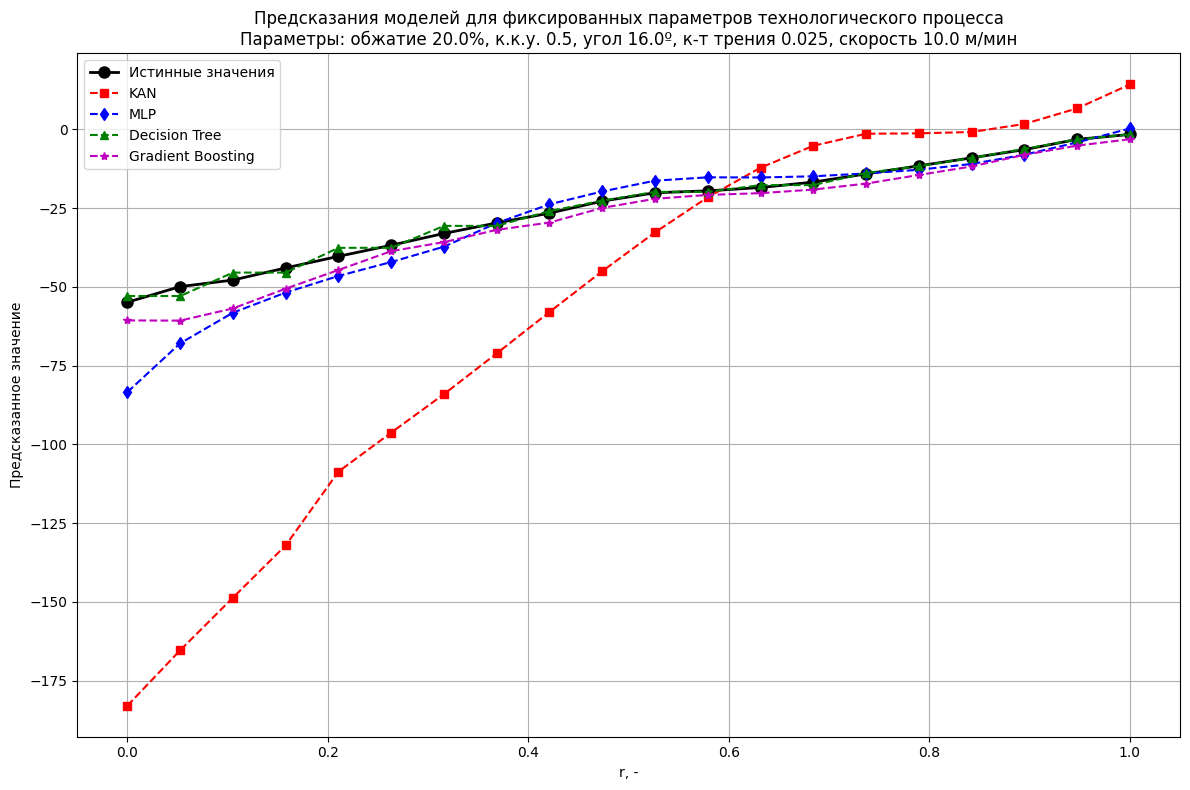

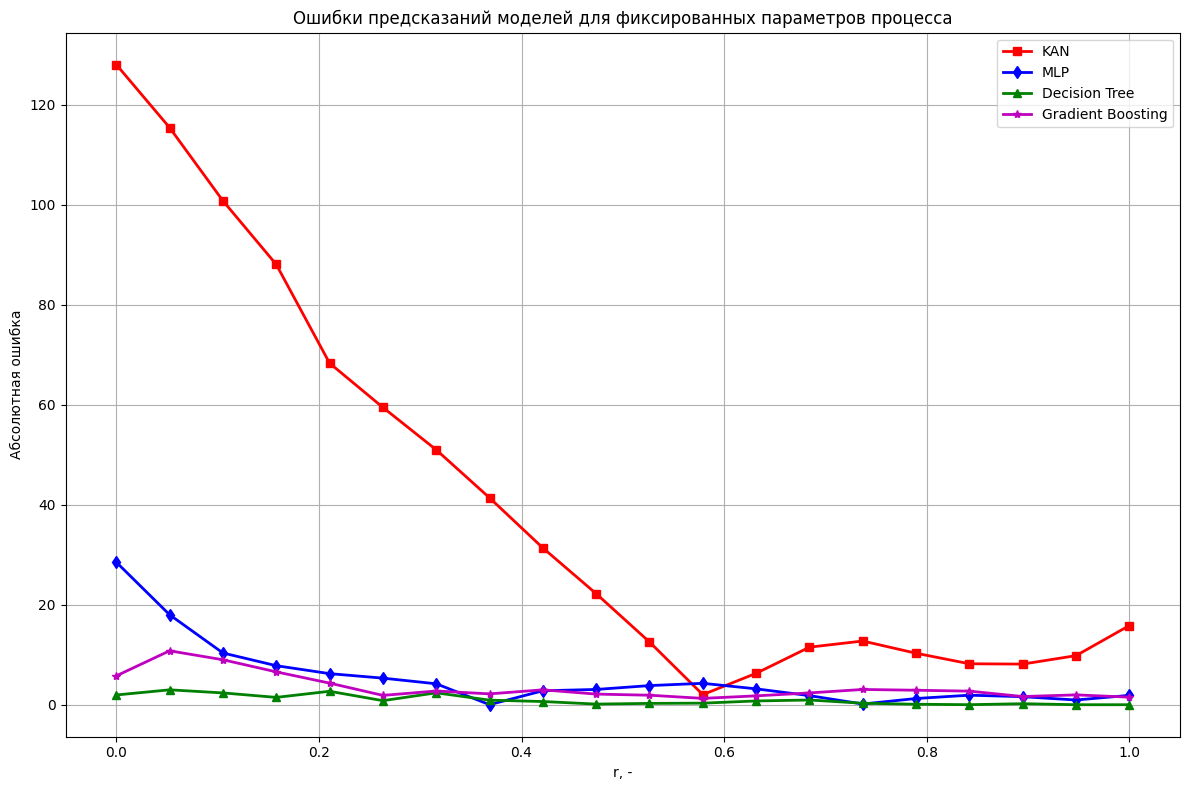

In [140]:
# Проверим структуру данных X_test для понимания параметров
print(f"Форма массива X_test: {X_test.shape}")
print(f"Первые несколько строк X_test:")
print(X_test[:5])

# Выберем несколько уникальных наборов первых 5 параметров (0-4) для анализа
unique_process_params = {}
for i in range(len(X_test)):
    # Используем кортеж из первых 5 параметров как ключ
    key = tuple(X_test[i, :5])
    if key in unique_process_params:
        unique_process_params[key].append(i)
    else:
        unique_process_params[key] = [i]

# Выведем информацию о найденных уникальных наборах параметров
print(f"\nНайдено {len(unique_process_params)} уникальных наборов первых 5 параметров")

# Выберем первый набор параметров для детального анализа (или можно выбрать другой)
selected_params = list(unique_process_params.keys())[0]
selected_indices = unique_process_params[selected_params]

formatted_params = format_process_params(selected_params)
print(f"\n{formatted_params}")
print(f"Количество образцов с этими параметрами: {len(selected_indices)}")

if len(selected_indices) > 1:
    # Отсортируем индексы по возрастанию значения X_test[5]
    selected_indices = sorted(selected_indices, key=lambda i: X_test[i, 5])
    
    # Получим соответствующие значения X_test[5] и предсказания моделей
    x_values = X_test[selected_indices, 5]
    y_true = y_test[selected_indices]
    kan_pred = kan_predictions_ravel[selected_indices]
    mlp_pred = mlp_predictions_ravel[selected_indices]
    dt_pred = dt_cur_y_pred_best[selected_indices]
    gb_pred = gb_cur_y_pred_best[selected_indices]
    
    # Отрисовка графика для выбранного процесса с изменением последнего параметра
    plt.figure(figsize=(12, 8))
    plt.plot(x_values, y_true, 'ko-', label='Истинные значения', linewidth=2, markersize=8)
    plt.plot(x_values, kan_pred, 'rs--', label='KAN', linewidth=1.5, markersize=6)
    plt.plot(x_values, mlp_pred, 'bd--', label='MLP', linewidth=1.5, markersize=6)
    plt.plot(x_values, dt_pred, 'g^--', label='Decision Tree', linewidth=1.5, markersize=6)
    plt.plot(x_values, gb_pred, 'm*--', label='Gradient Boosting', linewidth=1.5, markersize=6)
    
    plt.xlabel('r, -')
    plt.ylabel('Предсказанное значение')
    plt.title(
        f"Предсказания моделей для фиксированных параметров технологического процесса\n"
        f"{format_process_params(selected_params)}"
    )
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Отрисовка ошибок предсказаний для каждой модели
    plt.figure(figsize=(12, 8))
    plt.plot(x_values, np.abs(kan_pred - y_true), 'rs-', label='KAN', linewidth=2)
    plt.plot(x_values, np.abs(mlp_pred - y_true), 'bd-', label='MLP', linewidth=2)
    plt.plot(x_values, np.abs(dt_pred - y_true), 'g^-', label='Decision Tree', linewidth=2)
    plt.plot(x_values, np.abs(gb_pred - y_true), 'm*-', label='Gradient Boosting', linewidth=2)
    
    plt.xlabel('r, -')
    plt.ylabel('Абсолютная ошибка')
    plt.title('Ошибки предсказаний моделей для фиксированных параметров процесса')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для выбранного набора параметров (требуется минимум 2 точки)")

In [132]:
# Функция для поиска наборов параметров с заданным или большим количеством точек
def find_process_with_points(min_points=5):
    processes = []
    
    for params, indices in unique_process_params.items():
        if len(indices) >= min_points:
            processes.append((params, len(indices)))
    
    # Сортировка по убыванию количества точек
    processes.sort(key=lambda x: x[1], reverse=True)
    
    print(f"Найдено {len(processes)} процессов с {min_points} или более точками")
    for i, (params, count) in enumerate(processes[:5], 1):
        formatted_params = format_process_params(params)
        print(f"{i}. {formatted_params}, количество точек: {count}")
    
    return processes

# Найдем процессы с не менее чем 3 точками
processes_with_points = find_process_with_points(min_points=3)

Найдено 240 процессов с 3 или более точками
1. Параметры: обжатие 20.0%, к.к.у. 0.5, угол 16.0º, к-т трения 0.025, скорость 10.0 м/мин, количество точек: 20
2. Параметры: обжатие 15.0%, к.к.у. 0.5, угол 8.0º, к-т трения 0.050, скорость 20.0 м/мин, количество точек: 20
3. Параметры: обжатие 15.0%, к.к.у. 0.3, угол 20.0º, к-т трения 0.025, скорость 10.0 м/мин, количество точек: 20
4. Параметры: обжатие 5.0%, к.к.у. 0.3, угол 16.0º, к-т трения 0.025, скорость 10.0 м/мин, количество точек: 20
5. Параметры: обжатие 15.0%, к.к.у. 1.0, угол 12.0º, к-т трения 0.050, скорость 20.0 м/мин, количество точек: 20


Найдено 240 процессов с 3 или более точками
1. Параметры: обжатие 20.0%, к.к.у. 0.5, угол 16.0º, к-т трения 0.025, скорость 10.0 м/мин, количество точек: 20
2. Параметры: обжатие 15.0%, к.к.у. 0.5, угол 8.0º, к-т трения 0.050, скорость 20.0 м/мин, количество точек: 20
3. Параметры: обжатие 15.0%, к.к.у. 0.3, угол 20.0º, к-т трения 0.025, скорость 10.0 м/мин, количество точек: 20
4. Параметры: обжатие 5.0%, к.к.у. 0.3, угол 16.0º, к-т трения 0.025, скорость 10.0 м/мин, количество точек: 20
5. Параметры: обжатие 15.0%, к.к.у. 1.0, угол 12.0º, к-т трения 0.050, скорость 20.0 м/мин, количество точек: 20


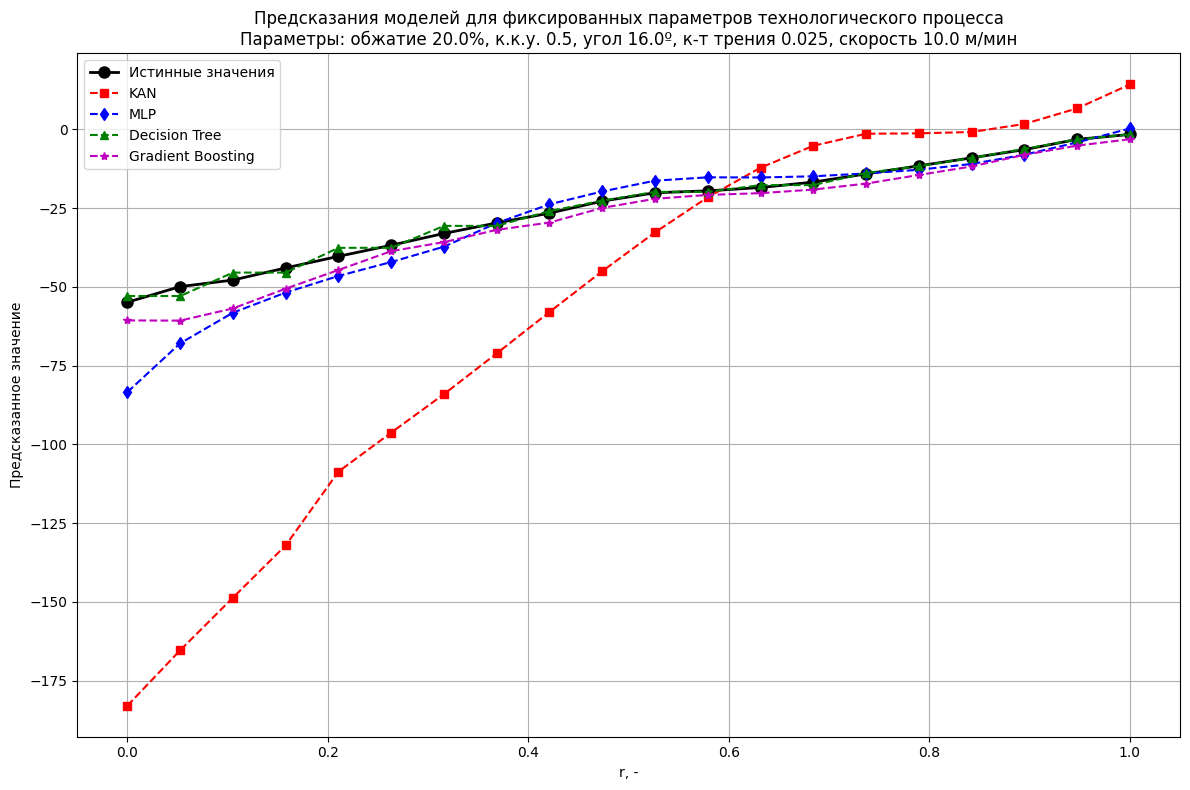

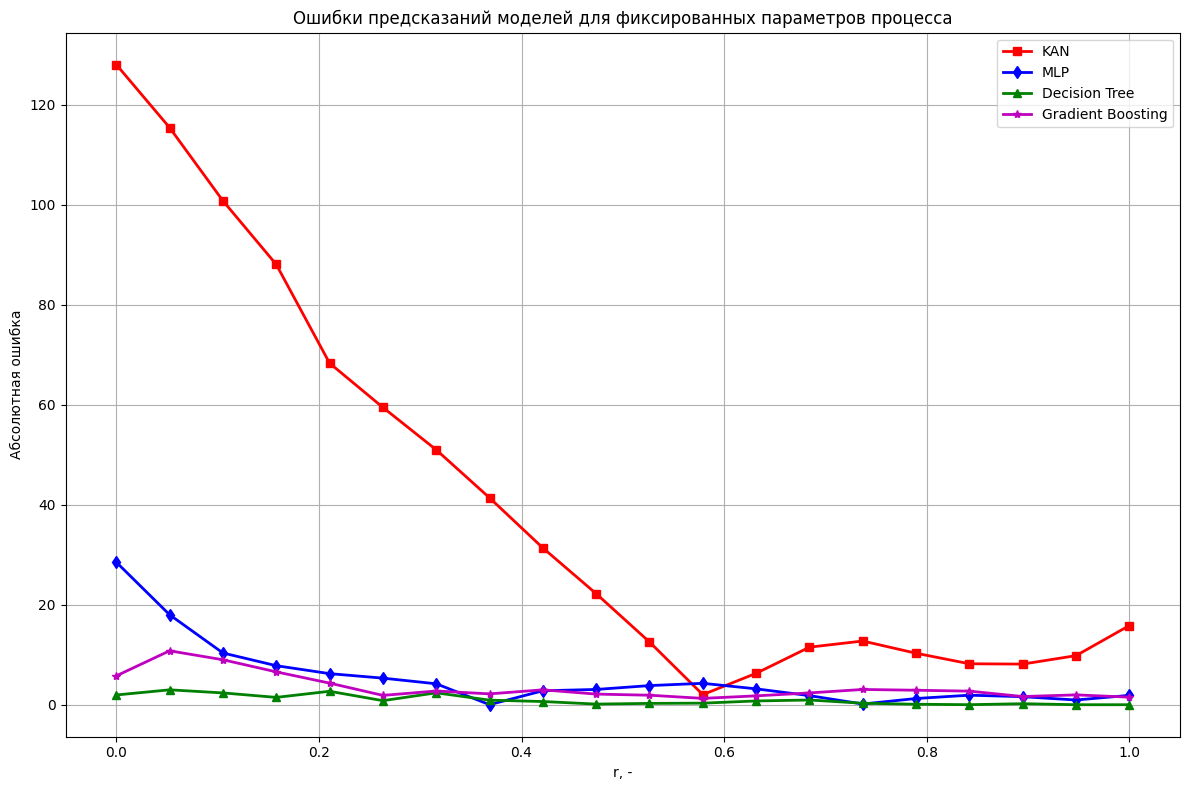

In [141]:
# Функция для построения графиков по выбранному процессу
def plot_predictions_for_process(process_index=0, min_points=3):
    processes = find_process_with_points(min_points)
    
    if not processes or process_index >= len(processes):
        print("Нет подходящих процессов или указан неверный индекс")
        return
    
    selected_params, _ = processes[process_index]
    selected_indices = unique_process_params[selected_params]
    
    # Отсортируем индексы по возрастанию значения X_test[5]
    selected_indices = sorted(selected_indices, key=lambda i: X_test[i, 5])
    
    # Получим соответствующие значения X_test[5] и предсказания моделей
    x_values = X_test[selected_indices, 5]
    y_true = y_test[selected_indices]
    kan_pred = kan_predictions_ravel[selected_indices]
    mlp_pred = mlp_predictions_ravel[selected_indices]
    dt_pred = dt_cur_y_pred_best[selected_indices]
    gb_pred = gb_cur_y_pred_best[selected_indices]
    
    # Отрисовка графика для выбранного процесса с изменением последнего параметра
    plt.figure(figsize=(12, 8))
    plt.plot(x_values, y_true, 'ko-', label='Истинные значения', linewidth=2, markersize=8)
    plt.plot(x_values, kan_pred, 'rs--', label='KAN', linewidth=1.5, markersize=6)
    plt.plot(x_values, mlp_pred, 'bd--', label='MLP', linewidth=1.5, markersize=6)
    plt.plot(x_values, dt_pred, 'g^--', label='Decision Tree', linewidth=1.5, markersize=6)
    plt.plot(x_values, gb_pred, 'm*--', label='Gradient Boosting', linewidth=1.5, markersize=6)
    
    plt.xlabel('r, -')
    plt.ylabel('Предсказанное значение')
    plt.title(
        f"Предсказания моделей для фиксированных параметров технологического процесса\n"
        f"{format_process_params(selected_params)}"
    )
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Отрисовка ошибок предсказаний для каждой модели
    plt.figure(figsize=(12, 8))
    plt.plot(x_values, np.abs(kan_pred - y_true), 'rs-', label='KAN', linewidth=2)
    plt.plot(x_values, np.abs(mlp_pred - y_true), 'bd-', label='MLP', linewidth=2)
    plt.plot(x_values, np.abs(dt_pred - y_true), 'g^-', label='Decision Tree', linewidth=2)
    plt.plot(x_values, np.abs(gb_pred - y_true), 'm*-', label='Gradient Boosting', linewidth=2)
    
    plt.xlabel('r, -')
    plt.ylabel('Абсолютная ошибка')
    plt.title('Ошибки предсказаний моделей для фиксированных параметров процесса')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return selected_indices

# Построим графики для процесса с наибольшим количеством точек (индекс 0)
selected_indices = plot_predictions_for_process(process_index=0, min_points=3)

## Интерпретация графиков для одного технологического процесса

Анализ предсказаний моделей для одного технологического процесса с изменением одного параметра позволяет сделать следующие выводы:

1. **Способность к обобщению**: Можно оценить, насколько хорошо каждая модель улавливает тренд при изменении параметра. Модель, которая точнее повторяет тренд истинных значений, обладает лучшей обобщающей способностью.

2. **Устойчивость к изменениям**: График показывает, какие модели более чувствительны к изменениям входного параметра, а какие более стабильны.

3. **Области применимости**: Можно определить диапазоны значений параметра, в которых конкретная модель работает лучше других.

4. **Физическая интерпретируемость**: График позволяет оценить, соответствуют ли предсказания модели физическому смыслу задачи (например, монотонность зависимости от параметра).

5. **Экстраполяция**: Можно увидеть, как модели ведут себя на краях диапазона значений параметра, что важно для оценки их применимости в новых условиях.

Такой анализ особенно ценен для инженерных приложений, где важно понимать, как модели будут работать при конкретных технологических режимах.

## Результаты МКЭ (метода конечных элементов)

В данном исследовании вектор `y_true` содержит результаты расчетов методом конечных элементов (МКЭ). Эти данные представляют собой "истинные" значения, которые мы стремимся предсказать с помощью моделей машинного обучения.

In [138]:
"""# Функция для вывода результатов МКЭ и предсказаний моделей для выбранного процесса
def show_fem_vs_models(process_index=0, min_points=3):
    processes = find_process_with_points(min_points)
    
    if not processes or process_index >= len(processes):
        print("Нет подходящих процессов или указан неверный индекс")
        return
    
    selected_params, _ = processes[process_index]
    selected_indices = unique_process_params[selected_params]
    formatted_params = format_process_params(selected_params)
    
    # Отсортируем индексы по возрастанию значения X_test[5]
    selected_indices = sorted(selected_indices, key=lambda i: X_test[i, 5])
    
    # Получим соответствующие значения скорости, результаты МКЭ и предсказания моделей
    speeds = X_test[selected_indices, 5]
    fem_results = y_test[selected_indices]
    kan_results = kan_predictions_ravel[selected_indices]
    mlp_results = mlp_predictions_ravel[selected_indices]
    dt_results = dt_cur_y_pred_best[selected_indices]
    gb_results = gb_cur_y_pred_best[selected_indices]
    
    # Создаем таблицу с полученными результатами
    results_df = pd.DataFrame({
        'Скорость (м/мин)': speeds,
        'Результаты МКЭ': fem_results,
        'KAN': kan_results,
        'MLP': mlp_results,
        'Decision Tree': dt_results,
        'Gradient Boosting': gb_results
    })
    
    # Выводим информацию о выбранном процессе
    print(f"Результаты МКЭ и предсказания моделей для процесса:")
    print(formatted_params)
    print("\nТаблица результатов:")
    
    # Форматируем таблицу для лучшего отображения
    pd.set_option('display.float_format', '{:.6f}'.format)
    display(results_df)
    
    # Таблица ошибок моделей относительно МКЭ
    print("\nОшибки моделей (абсолютные и относительные):")
    errors_df = pd.DataFrame({
        'Скорость (м/мин)': speeds,
        'KAN (абс.)': np.abs(kan_results - fem_results),
        'MLP (абс.)': np.abs(mlp_results - fem_results),
        'Decision Tree (абс.)': np.abs(dt_results - fem_results),
        'Gradient Boosting (абс.)': np.abs(gb_results - fem_results),
        'KAN (%%)': np.abs(kan_results - fem_results) / np.abs(fem_results) * 100,
        'MLP (%%)': np.abs(mlp_results - fem_results) / np.abs(fem_results) * 100,
        'Decision Tree (%%)': np.abs(dt_results - fem_results) / np.abs(fem_results) * 100,
        'Gradient Boosting (%%)': np.abs(gb_results - fem_results) / np.abs(fem_results) * 100
    })
    display(errors_df)
    
    # Вычислим и выведем средние ошибки для этого конкретного процесса
    print("\nСредние ошибки моделей для данного процесса:")
    mean_abs_errors = {
        'KAN': np.mean(np.abs(kan_results - fem_results)),
        'MLP': np.mean(np.abs(mlp_results - fem_results)),
        'Decision Tree': np.mean(np.abs(dt_results - fem_results)),
        'Gradient Boosting': np.mean(np.abs(gb_results - fem_results))
    }
    
    mean_rel_errors = {
        'KAN': np.mean(np.abs(kan_results - fem_results) / np.abs(fem_results) * 100),
        'MLP': np.mean(np.abs(mlp_results - fem_results) / np.abs(fem_results) * 100),
        'Decision Tree': np.mean(np.abs(dt_results - fem_results) / np.abs(fem_results) * 100),
        'Gradient Boosting': np.mean(np.abs(gb_results - fem_results) / np.abs(fem_results) * 100)
    }
    
    mean_errors_df = pd.DataFrame({
        'Средняя абс. ошибка': mean_abs_errors,
        'Средняя отн. ошибка (%)': mean_rel_errors
    })
    display(mean_errors_df)
    
    return results_df, errors_df, mean_errors_df

# Вызываем функцию для первого процесса с наибольшим количеством точек
results_df, errors_df, mean_errors_df = show_fem_vs_models(process_index=0, min_points=3)"""

'# Функция для вывода результатов МКЭ и предсказаний моделей для выбранного процесса\ndef show_fem_vs_models(process_index=0, min_points=3):\n    processes = find_process_with_points(min_points)\n    \n    if not processes or process_index >= len(processes):\n        print("Нет подходящих процессов или указан неверный индекс")\n        return\n    \n    selected_params, _ = processes[process_index]\n    selected_indices = unique_process_params[selected_params]\n    formatted_params = format_process_params(selected_params)\n    \n    # Отсортируем индексы по возрастанию значения X_test[5]\n    selected_indices = sorted(selected_indices, key=lambda i: X_test[i, 5])\n    \n    # Получим соответствующие значения скорости, результаты МКЭ и предсказания моделей\n    speeds = X_test[selected_indices, 5]\n    fem_results = y_test[selected_indices]\n    kan_results = kan_predictions_ravel[selected_indices]\n    mlp_results = mlp_predictions_ravel[selected_indices]\n    dt_results = dt_cur_y_pre

Найдено 240 процессов с 3 или более точками
1. Параметры: обжатие 20.0%, к.к.у. 0.5, угол 16.0º, к-т трения 0.025, скорость 10.0 м/мин, количество точек: 20
2. Параметры: обжатие 15.0%, к.к.у. 0.5, угол 8.0º, к-т трения 0.050, скорость 20.0 м/мин, количество точек: 20
3. Параметры: обжатие 15.0%, к.к.у. 0.3, угол 20.0º, к-т трения 0.025, скорость 10.0 м/мин, количество точек: 20
4. Параметры: обжатие 5.0%, к.к.у. 0.3, угол 16.0º, к-т трения 0.025, скорость 10.0 м/мин, количество точек: 20
5. Параметры: обжатие 15.0%, к.к.у. 1.0, угол 12.0º, к-т трения 0.050, скорость 20.0 м/мин, количество точек: 20


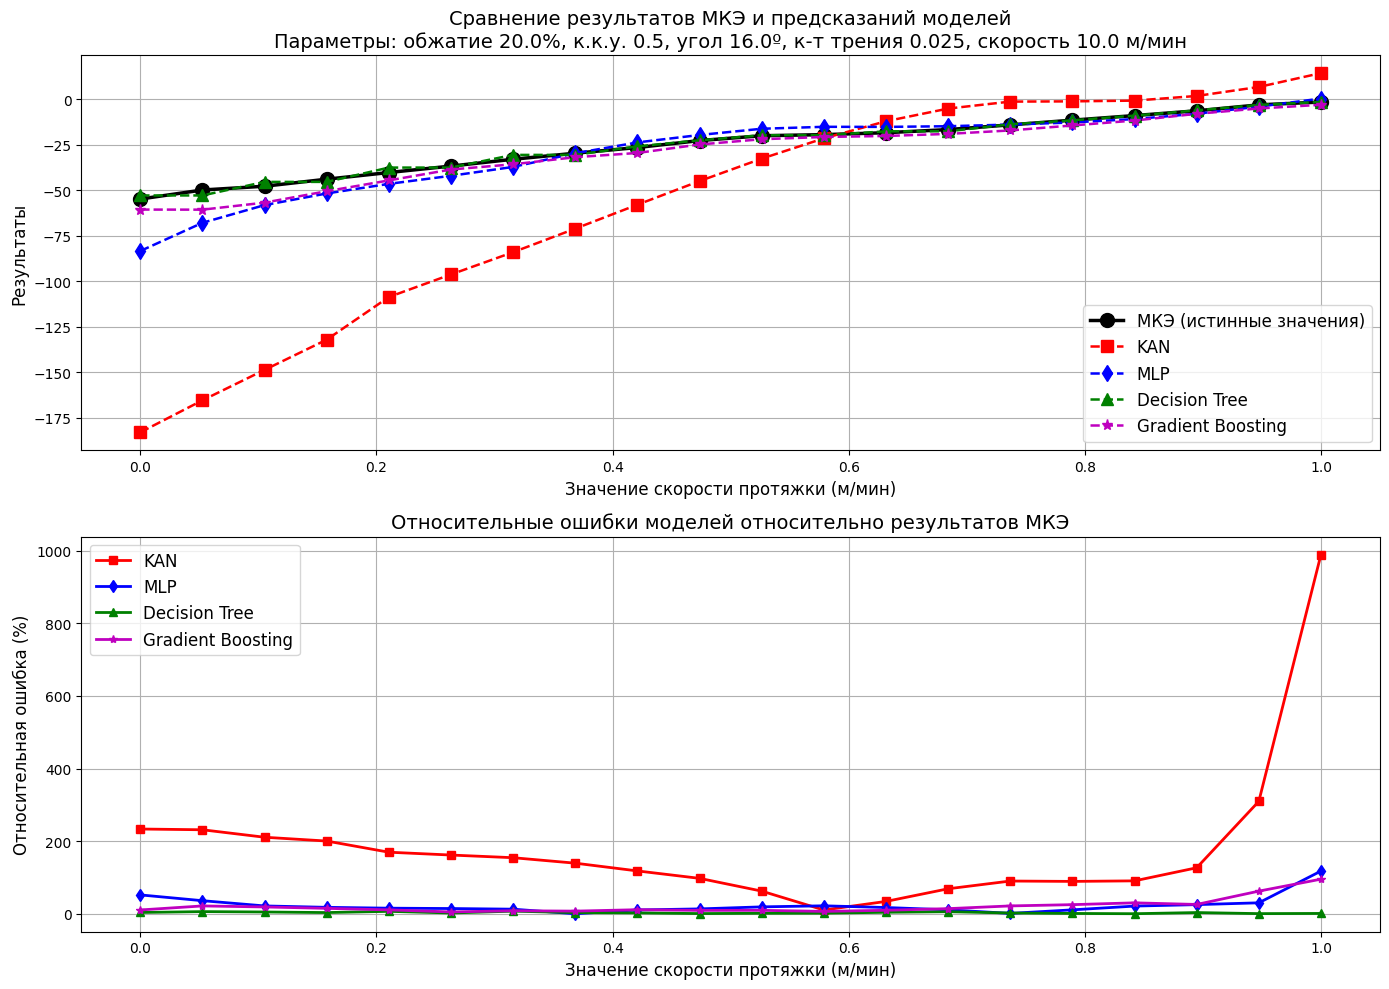

In [139]:
# Функция для визуализации результатов МКЭ и предсказаний моделей
def visualize_fem_vs_models(process_index=0, min_points=3):
    processes = find_process_with_points(min_points)
    
    if not processes or process_index >= len(processes):
        print("Нет подходящих процессов или указан неверный индекс")
        return
    
    selected_params, _ = processes[process_index]
    selected_indices = unique_process_params[selected_params]
    formatted_params = format_process_params(selected_params)
    
    # Отсортируем индексы по возрастанию значения X_test[5]
    selected_indices = sorted(selected_indices, key=lambda i: X_test[i, 5])
    
    # Получим соответствующие значения скорости, результаты МКЭ и предсказания моделей
    speeds = X_test[selected_indices, 5]
    fem_results = y_test[selected_indices]
    kan_results = kan_predictions_ravel[selected_indices]
    mlp_results = mlp_predictions_ravel[selected_indices]
    dt_results = dt_cur_y_pred_best[selected_indices]
    gb_results = gb_cur_y_pred_best[selected_indices]
    
    # Построение графика сравнения МКЭ и предсказаний моделей
    plt.figure(figsize=(14, 10))
    
    # Верхняя часть графика - абсолютные значения
    plt.subplot(2, 1, 1)
    plt.plot(speeds, fem_results, 'ko-', label='МКЭ (истинные значения)', linewidth=2.5, markersize=10)
    plt.plot(speeds, kan_results, 'rs--', label='KAN', linewidth=1.8, markersize=8)
    plt.plot(speeds, mlp_results, 'bd--', label='MLP', linewidth=1.8, markersize=8)
    plt.plot(speeds, dt_results, 'g^--', label='Decision Tree', linewidth=1.8, markersize=8)
    plt.plot(speeds, gb_results, 'm*--', label='Gradient Boosting', linewidth=1.8, markersize=8)
    
    plt.xlabel('Значение скорости протяжки (м/мин)', fontsize=12)
    plt.ylabel('Результаты', fontsize=12)
    plt.title(f'Сравнение результатов МКЭ и предсказаний моделей\n{formatted_params}', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    
    # Нижняя часть графика - относительные ошибки
    plt.subplot(2, 1, 2)
    plt.plot(speeds, np.abs(kan_results - fem_results) / np.abs(fem_results) * 100, 'rs-', label='KAN', linewidth=2)
    plt.plot(speeds, np.abs(mlp_results - fem_results) / np.abs(fem_results) * 100, 'bd-', label='MLP', linewidth=2)
    plt.plot(speeds, np.abs(dt_results - fem_results) / np.abs(fem_results) * 100, 'g^-', label='Decision Tree', linewidth=2)
    plt.plot(speeds, np.abs(gb_results - fem_results) / np.abs(fem_results) * 100, 'm*-', label='Gradient Boosting', linewidth=2)
    
    plt.xlabel('Значение скорости протяжки (м/мин)', fontsize=12)
    plt.ylabel('Относительная ошибка (%)', fontsize=12)
    plt.title('Относительные ошибки моделей относительно результатов МКЭ', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return speeds, fem_results, kan_results, mlp_results, dt_results, gb_results

# Визуализируем результаты МКЭ и моделей на графиках
speeds, fem_results, kan_results, mlp_results, dt_results, gb_results = visualize_fem_vs_models(process_index=0, min_points=3)